# Capstone Project 1- Forecasting short term solar energy for 98 stations

# Introduction
The purpose of the current project is to do data wrangling to prepare the data for the next step of the original project, - to forecast day ahead solar energy production at Oklahoma Mesonet stations using linear regression machine learning algorithm. The complete dataset required for this project is obtained from the Kaggle site (https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest). Although data wrangling is implemented on all input variables only the temperature data is presented in this part of work for brevity.

# Importing necessary modules

In [63]:
# importing necessary modules for data acquire and data wrangling
import netCDF4 as nc
import glob
import os
import numpy as np
import pandas as pd
import math
from scipy import interpolate
import matplotlib.pyplot as plt
from datetime import datetime


# importing necessary modules for model prediction
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Data acquire,  reshaping, data quality check
The dataset was downloaded from the Kaggle site in netcdf files. We need only 5 x 10 = 50 grid points (from lat: 33 - 37 N (i.e., 5 grid points), lon: 257 - 266 W (i.e., 10 grid points)) instead of 9 x 16 grid points to cover all Mesonet stations. Downscaling to a smaller grid will reduce the space for data storage greatly. The original dataset has the dimension (5113, 11, 5, 9, 16). The last two dimensions corresond to lattitude and longitude. Extracting the data for each grid points reduce the dimension to (5113, 11, 5). These dimensions correspond to time, model ensemble outcome and timesteps each day: 11 model ensemble predicting weather variables 5 times each day resulting to a total of 5113 days of dataset. Then it is reshaped into a 2 dimensional dataset, i.e., (5113, 55) from 3 dimensional dataset, i.e., (5113, 11, 5) and written in files for each grid point.


In [ ]:
steps = ['Train', 'Test']
step_file = ['train', 'test']
mainpath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\"
steppath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Solar energy/"
for m in range(len(steps)):
    step_files = steppath + 'gefs_' + step_file[m] +'/'+ step_file[m] + '/*.nc' 
    #print(step_files)
    ###########
    # listing all files in Train folder
    files = glob.glob(step_files)
    for file in files:
        # load dataset and select the necessary variable to process
        data = nc.Dataset(file)
        v = list(data.variables.keys())
        var = v[-1]
        #print('Variable name:', var)

        # data variables and their structure
        d = list(data.dimensions.values())
        #print(d)

        lat = data.variables['lat']
        #print(lat.shape)
        lon = data.variables['lon']
        #print(lon.shape)
        t = data.variables[var] # since last key is of our interest
        #print(t.shape)
        l = lat[:]
        n = lon[:]
        # index of test/ train file 
        index_file1 = file.index(step_file[m] + '\\') + len(step_file[m] + '\\')
        file1 = file[index_file1:]
        file_name = file1[:-35]
        #print('Variable name:', var, ', Variable folder:', file_name)

        # reshaping data file for a smaller grid (latitude range 33 - 38, longitude range 257 - 267) which cover all stations
        var_name = file_name
        var_new = file_name

        for lat in range(33, 38): 
            l_in = np.where(l == lat)[0][0]
            for lon in range(257, 267):
                n_in = np.where(n == lon)[0][0]
                filename = var_new +'_'+str(lat)+ '_'+str(lon)
                fileval = t[:,:,:,l_in,n_in]

                # reshaping fileval from (5113, 11, 5) to (5113, 55)
                fileval = fileval.reshape(fileval.shape[0], fileval.shape[1]*fileval.shape[2])

                # saving the  data for each grid point
                #filepath_ = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Solar energy/Train/"
                filepath_ = steppath + '/' + steps[m] +'/'
                filepath__ = filepath_ + var_name
                # creating directory for files
                os.makedirs(filepath__, exist_ok=True)
                filepath = filepath__ + '/' + filename +str('.csv')
                np.savetxt(filepath, fileval, delimiter=',', fmt = "%0.06f")

                ###
        station_loc = pd.read_csv("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\station_info.csv")
        for i in range(len(station_loc.stid)):
            stn = station_loc.stid[i]
            stn_n = station_loc.nlat[i]
            stn_l = station_loc.elon[i] + 360
            Xnew = stn_l
            Ynew = stn_n

            # lattitude longitude for the 4 surrounding grids
            str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
                    str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
                    str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
                    str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]
            #print('lattitude and longitude of the station:', Xnew, Ynew)
            #print('lattitude and longitude of surrounding grids are (in format lat_lon):', str_list)

            # setting filepath for the variable at the surrounding grids
            filepath_ = mainpath + steps[m] + '\\'
            filepath = filepath_ + var_name + '\\'+ var_new + '_'
            filename1 = filepath + str_list[0] + '.csv'
            filename2 = filepath + str_list[1] + '.csv'
            filename3 = filepath + str_list[2] + '.csv'
            filename4 = filepath + str_list[3] + '.csv'
            filenames = [filename1, filename2, filename3, filename4]

                # creating subplots for each grid point
            p_con = pd.DataFrame()
            p_des_con = pd.DataFrame()
            avg_grid = pd.DataFrame()

            # for each grid point surrounding the station
            for k in range(4):

                p_grid = pd.read_csv(filenames[k], header=None)

                # Null data check
                assert pd.notnull(p_grid).all().all()

                # reshaping: from 2d:5113 x 55 to 1d: 281215
                p = p_grid.melt()

                # statistical summary
                p_des = p.describe().value
                p_des_con = pd.concat([p_des_con, p_des], axis=1 )
                p_con = pd.concat([p_con, p['value']], axis=1 )

                # frequency distribution of the variable    

                # Averaging data over model estimation and timesteps. There are 5 timesteps in a day (lets say: t0, t1, t2, t3, t4)
                #We will combine 11 model prediction at each timestep first and then average over time.

                # looping over timesteps
                model_mean_t=pd.DataFrame()
                for j in range(0,5):

                    model_en = p_grid[j]
                    for i in range(0,50,5):
                        model_en = pd.concat([model_en, p_grid[i+j+5]], axis=1)

                    # averaging model ensemble    
                    model_mean = np.mean(model_en, axis=1)

                    model_mean_t = pd.concat([model_mean_t, model_mean], axis=1)

                # averaging over timesteps
                model_mean_t_mean = np.mean(model_mean_t, axis=1)

                # concating avg from all 4 grids
                avg_grid = pd.concat([avg_grid, model_mean_t_mean], axis=1)

                # saving the averaged value from 4 surrounding grids
                
                filepath1 = mainpath + steps[m] + '\\' +  var_name + '\\'+ 'model_' + var_new + '_mean_'
                filename= filepath1 + str_list[k] + '.csv'
                np.savetxt(filename, model_mean_t_mean, delimiter=',', fmt = "%0.06f")

            p_des_con.columns = str_list
            p_con.columns = str_list

            #print('')
            #print('Summary statistics of the variable at 4 surrounding grid points:')
            #print(p_des_con)
            avg_grid.columns = str_list

            # evaluate correlation among the gridpoint variables
            #print('')
            #print('Correlation of the surrounding grid variables:')
            #print(avg_grid.corr())


            # Interpolating the variable values from 4 surrounding grid points to the station

            x,y = np.meshgrid([math.floor(Xnew), math.ceil(Xnew)],[math.floor(Ynew), math.ceil(Ynew)])

            # Setting filepath
            # filename: str_list: math.floor(Xnew), math.ceil(Xnew), math.floor(Ynew), math.ceil(Ynew)
            str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
                        str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
                        str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
                        str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]

            filepath = mainpath + steps[m] + '\\' + var_name + '\\model_' + var_new + '_mean_'
            filename1 = filepath + str_list[0] + '.csv'
            filename2 = filepath + str_list[1] + '.csv'
            filename3 = filepath + str_list[2] + '.csv'
            filename4 = filepath + str_list[3] + '.csv'
            filenames = [filename1, filename2, filename3, filename4]

            # loading data for surrounding grids
            var1 = pd.read_csv(filename1, header=None)
            var1 = var1.rename(columns={var1.columns[0] : 'x1y1'})
            var2 = pd.read_csv(filename2, header=None)
            var2 = var2.rename(columns={var2.columns[0] : 'x2y1'})
            var3 = pd.read_csv(filename3, header=None)
            var3 = var3.rename(columns={var3.columns[0] : 'x1y2'})
            var4 = pd.read_csv(filename4, header=None)
            var4 = var4.rename(columns={var4.columns[0] : 'x2y2'})
            var = pd.concat([var1, var2, var3, var4], axis=1)

            # interpolating to the station
            # z structure([(34,261), (34, 262)], [(35, 261), (35, 262)])
            var_station = []
            for row in var.values:
                z = [row[0], row[1]], [row[2], row[3]]
                f = interpolate.interp2d(x,y,z,kind='linear')
                interp_val=f(Xnew,Ynew)
                var_station = np.append(var_station, interp_val)

            # saving interpolated station data

            filepath_var = mainpath + steps[m] + '\\' + var_name + '\\' + var_new +'_' + stn + '.csv'
            np.savetxt(filepath_var, var_station, delimiter=',', fmt = "%0.06f")


## Predictive modeling

Three machine learning algorithms were enployed to predict solar energy: linear regression, gradient boosting and random forest.
The parameters in gradient boosting were optimized as shown on the Sample station 'ACME'. The normalized root mean square from all three algorithm were similar. Finally we adopted the simplest of all, linear regression model which resulted a normalized root mean square error of 0.199. 

## Linear regression

Root Mean Squared Error Linear Regression: 0.20068597732992505


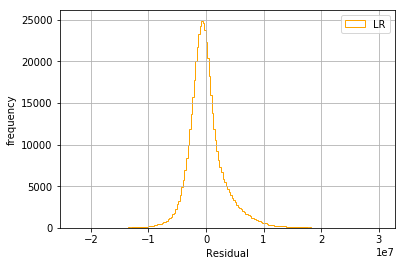

In [69]:
# predictive model: Training and testing dataset
mainpath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Train"
filepath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Solar energy/Train/*"
station_loc = pd.read_csv("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\station_info.csv")
# loading traget dataset
output = pd.read_csv("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\train.csv")
rmse_lr = []
residual_lr = []

# loading training dataset

for i in range(len(station_loc.stid)):
    stn = station_loc.stid[i]
    x = pd.DataFrame()
    # train dataset file location 
    files = glob.glob(filepath)
    for f in files:
        index_f = len(filepath) -1
        var = f[index_f:]
        var_path = mainpath +'\\' + var + '\\'
        #print(var)
        stn_path = var_path + var + '_' + stn + '.csv'
        #print(stn_path)
        data = pd.read_csv(stn_path, header=None)
        #print(data)
        x = pd.concat([x, data], axis=1)
    #print(x)
    x.columns = ['dswrfs', 'dlwrfs', 'uswrfs', 'ulwrfs', 'ulwrf', 'ts', 't', 'mint', 'maxt', 'tc', 'tcc', 'h', 'pw', 'precip', 'pr']
    X = x.values
    
    y0 = output[stn]
    y = y0.values
    
    # predictive models
    # linear regression after scaled input dataset and pipeline
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    steps = [('scaler', StandardScaler()),
             ('linreg', LinearRegression())]
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Create a regression object: reg
    reg = LinearRegression()
    fitted = pipeline.fit(X_train, y_train)
    y_fit_trn_lr = pipeline.predict(X_train)
    y_pred_tst = pipeline.predict(X_test)

    # metrics
    rmse_lr = np.append(rmse_rf, np.sqrt(mean_squared_error(y_test, y_pred_tst))/np.mean(y_test))
    

    # residual distribution for the whole training set
    y_fitted_lr = pipeline.predict(X)
    residual_lr = np.append(residual_lr, (y_fitted_lr - y))
    
#metrics for rf model
avg_rmse_lr = np.mean(rmse_lr)
print("Root Mean Squared Error Linear Regression: {}".format(avg_rmse_lr))


fig, ax = plt.subplots()
ax.hist(residual_lr, bins=200, color="orange", label='LR', histtype='step')
ax.set_xlabel('Residual')
ax.set_ylabel('frequency')
ax.legend(loc='upper right')
ax.grid(True)
plt.rcParams["figure.figsize"] = [6,4]
plt.show()

## Gradient boosting

Root Mean Squared Error gradient boosting: 0.20437463770390626


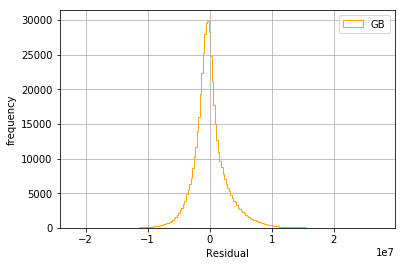

In [67]:
# predictive model: Training and testing dataset
rmse_gb = []
residual_gb = []

# loading training dataset

for i in range(len(station_loc.stid)):
    stn = station_loc.stid[i]
    x = pd.DataFrame()
    # train dataset file location 
    files = glob.glob(filepath)
    for f in files:
        index_f = len(filepath) -1
        var = f[index_f:]
        var_path = mainpath +'\\' + var + '\\'
        #print(var)
        stn_path = var_path + var + '_' + stn + '.csv'
        #print(stn_path)
        data = pd.read_csv(stn_path, header=None)
        #print(data)
        x = pd.concat([x, data], axis=1)
    #print(x)
    x.columns = ['dswrfs', 'dlwrfs', 'uswrfs', 'ulwrfs', 'ulwrf', 'ts', 't', 'mint', 'maxt', 'tc', 'tcc', 'h', 'pw', 'precip', 'pr']
    X = x.values
    
    y0 = output[stn]
    y = y0.values
    
    # predictive models
    # random forest regression after scaled input dataset and pipeline
    params = {'n_estimators': 10,'max_depth': 5,'learning_rate': 0.4,'criterion': 'mse'}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    steps = [('scaler', StandardScaler()),
             ('GBreg', ensemble.GradientBoostingRegressor(**params))]
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Create a regression object: reg
    gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)
    fitted = pipeline.fit(X_train, y_train)
    y_fit_trn_gb = pipeline.predict(X_train)
    y_pred_tst = pipeline.predict(X_test)

    # metrics
    rmse_gb = np.append(rmse_gb, np.sqrt(mean_squared_error(y_test, y_pred_tst))/np.mean(y_test))
    

    # residual distribution for the whole training set
    y_fitted_gb = pipeline.predict(X)
    residual_gb = np.append(residual_gb, (y_fitted_gb - y))
    
#metrics for rf model
avg_rmse_gb = np.mean(rmse_gb)
print("Root Mean Squared Error gradient boosting: {}".format(avg_rmse_gb))


fig, ax = plt.subplots()
ax.hist(residual_gb, bins=200, color="orange", label='GB', histtype='step')
ax.set_xlabel('Residual')
ax.set_ylabel('frequency')
ax.legend(loc='upper right')
ax.grid(True)
plt.rcParams["figure.figsize"] = [6,4]
plt.show()

## Random forest

Root Mean Squared Error Random forest: 0.20063314704051516


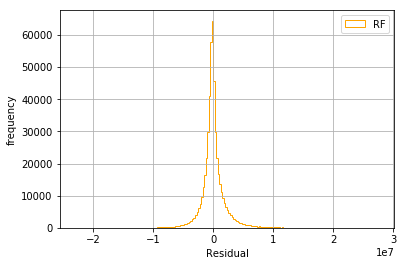

In [61]:
# predictive model: Training and testing dataset
rmse_rf = []
residual_rf = []

# loading training dataset

for i in range(len(station_loc.stid)):
    stn = station_loc.stid[i]
    x = pd.DataFrame()
    # train dataset file location 
    files = glob.glob(filepath)
    for f in files:
        index_f = len(filepath) -1
        var = f[index_f:]
        var_path = mainpath +'\\' + var + '\\'
        #print(var)
        stn_path = var_path + var + '_' + stn + '.csv'
        #print(stn_path)
        data = pd.read_csv(stn_path, header=None)
        #print(data)
        x = pd.concat([x, data], axis=1)
    #print(x)
    x.columns = ['dswrfs', 'dlwrfs', 'uswrfs', 'ulwrfs', 'ulwrf', 'ts', 't', 'mint', 'maxt', 'tc', 'tcc', 'h', 'pw', 'precip', 'pr']
    X = x.values
    
    y0 = output[stn]
    y = y0.values
    
    # predictive models
    # random forest regression after scaled input dataset and pipeline
    params = {'n_estimators': 15000, 'criterion': 'mse'}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    steps = [('scaler', StandardScaler()),
             ('rf', ensemble.RandomForestRegressor(**params))]
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Create a regression object: reg
    rf = RandomForestRegressor(n_estimators = 1500, random_state = 42)
    fitted = pipeline.fit(X_train, y_train)
    y_fit_trn_rf = pipeline.predict(X_train)
    y_pred_tst = pipeline.predict(X_test)

    # metrics
    rmse_rf = np.append(rmse_rf, np.sqrt(mean_squared_error(y_test, y_pred_tst))/np.mean(y_test))
    

    # residual distribution for the whole training set
    y_fitted_rf = pipeline.predict(X)
    residual_rf = np.append(residual_rf, (y_fitted_rf - y))
    
#metrics for rf model
avg_rmse_rf = np.mean(rmse_rf)
print("Root Mean Squared Error Random forest: {}".format(avg_rmse_rf))


fig, ax = plt.subplots()
ax.hist(residual_rf, bins=200, color="orange", label='RF', histtype='step')
ax.set_xlabel('Residual')
ax.set_ylabel('frequency')
ax.legend(loc='upper right')
ax.grid(True)
plt.rcParams["figure.figsize"] = [6,4]
plt.show()

All the three ML algorithms produced similar results. As linear regression is the simplest among these 3, we will use it for final prediction of solar energy from 2008 - 2012.

In [68]:
# prediction dataset
mainpath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Test"
filepath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Solar energy/Test/*"

y_target_lr = []
for i in range(len(station_loc.stid)):
    stn = station_loc.stid[i]
    # loading training data
    xt = pd.DataFrame()
    # train dataset file location 
    files = glob.glob(filepath)
    for f in files:
        index_f = len(filepath) -1
        var = f[index_f:]
        var_path = mainpath +'\\' + var + '\\'
        #print(var)
        stn_path = var_path + var + '_' + stn + '.csv'
        #print(stn_path)
        data = pd.read_csv(stn_path, header=None)
        #print(data)
        xt = pd.concat([xt, data], axis=1)
    #print(xt)
    xt.columns = ['dswrfs', 'dlwrfs', 'uswrfs', 'ulwrfs', 'ulwrf', 'ts', 't', 'mint', 'maxt', 'tc', 'tcc', 'h', 'pw', 'precip', 'pr']
    X_target = xt.values
    
    # prediction on unseen dataset
    y_target_lr.append(pipeline.predict(X_target))
    
y_target_lr = np.array(y_target_lr).T.tolist()
filepath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\" + 'sampleSubmission_lr.csv'
np.savetxt(filepath, y_target_lr, delimiter=',', fmt = "%0.06f")